# Cyanobacteria Toxicity Classification Notebook with Cross-Validation

## 1. Setup & Configuration

In [7]:
import os
from datetime import date
import math
import subprocess
import yaml
import pandas as pd
import torch
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import models, datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from src.config_utils import load_config
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset
import torch.optim as optim
from PIL import Image
import torch.nn.functional as F
import copy
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.transforms as T
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    brier_score_loss,
    accuracy_score
)
from sklearn.calibration import calibration_curve
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Chargement de la config
config = load_config(path='../configs/config_finetune_resnet18.yaml')

# Répertoires de sortie
FIG_OUT = os.path.join('..', 'outputs', 'figures', 'Switzerland', 'finetune_resnet18')
os.makedirs(FIG_OUT, exist_ok=True)

# Génération du Run ID : date + commit Git
today = date.today().isoformat()
commit = subprocess.check_output(["git","rev-parse","--short","HEAD"]).decode().strip()
run_id = f"{today}_{commit}"

print("Run ID :", run_id)


Run ID : 2025-07-26_65513ae


## 2. Data Preparation

In [8]:
# Transforms avec RandomErasing pour dropout spatial
data_cfg = config['augmentation']

train_transform = T.Compose([
    # 1) Crop aléatoire + scale varié
    T.RandomResizedCrop(size=tuple(data_cfg['resize']),
                        scale=(0.8, 1.0)),
    # 2) Flips horizontal + vertical
    T.RandomHorizontalFlip(p=0.5 if data_cfg['horizontal_flip'] else 0.0),
    T.RandomVerticalFlip(p=0.5 if data_cfg['vertical_flip'] else 0.0),
    # 3) Rotation légère
    T.RandomRotation(degrees=data_cfg['rotation']),
    # 4) Variation colorimétrique
    T.ColorJitter(brightness=data_cfg['color_jitter']['brightness'],
                  contrast=  data_cfg['color_jitter']['contrast'],
                  saturation=data_cfg['color_jitter']['saturation'],
                  hue=       data_cfg['color_jitter']['hue']),
    # 5) Passage en tenseur + normalisation
    T.ToTensor(),
    T.Normalize(mean=data_cfg['normalization']['mean'],
                std= data_cfg['normalization']['std']),
    # 6) Masquage partiel (Random Erasing)
    T.RandomErasing(p=data_cfg['random_erasing']['p'],
                    scale=tuple(data_cfg['random_erasing']['scale']),
                    ratio=tuple(data_cfg['random_erasing']['ratio']))
])

val_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_cfg['normalization']['mean'],
                         std=data_cfg['normalization']['std'])
])


In [9]:
# Chargement du dataset et Stratified K-Fold
dataset = datasets.ImageFolder(
    root=os.path.join('..', config['data']['path']),
    transform=train_transform
)
targets = np.array(dataset.targets)


paths = [path for path, _ in dataset.samples]
groups = [os.path.basename(p).split('_')[0] for p in paths]

df = pd.DataFrame({'target': targets, 'group': groups})
groups_per_class = df.groupby('target')['group'].nunique().to_dict()
n_souches_0 = groups_per_class.get(0, 0)
n_souches_1 = groups_per_class.get(1, 0)
print(f"{n_souches_0} souches non‑toxiques, {n_souches_1} souches toxiques.")

n_splits = min(
    df.groupby('target')['group'].nunique().min(),
    5
)

print(f"Utilisation de n_splits = {n_splits}")

sgkf = StratifiedGroupKFold(
    n_splits=n_splits,
    shuffle=True,
    random_state=42
)

valid_folds = []
for fold, (train_idx, val_idx) in enumerate(
        sgkf.split(np.zeros(len(targets)), targets, groups)
    ):
    # on skippe les folds mono‑classe en validation
    if len(np.unique(targets[val_idx])) < 2:
        print(f"Skip fold {fold+1} (mono‑classe en val)")
        continue
    valid_folds.append((fold, train_idx, val_idx))

print(f"{len(valid_folds)} folds valides sur {n_splits}")

9 souches non‑toxiques, 8 souches toxiques.
Utilisation de n_splits = 5
Skip fold 2 (mono‑classe en val)
Skip fold 5 (mono‑classe en val)
3 folds valides sur 5


## 3. Model Definition

In [10]:
# === EarlyStopping utility ===
class EarlyStopping:
    def __init__(self, patience=3, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


In [11]:
# Définition du modèle, critère et optimizer
device = torch.device(config['training']['device'])
model = models.resnet18(
    weights=ResNet18_Weights.DEFAULT if config['model']['pretrained'] else None
)

# 1) Tout gèlé
for param in model.parameters():
    param.requires_grad = False

# 2) Nouvelle tête (dropout léger)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(config["training"]["dropout_prob"]),
    nn.Linear(num_ftrs, config['model']['num_classes'])
)

model = model.to(device)


criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [12]:
def train_and_eval_fold(fold, train_idx, val_idx):
    # 1) Préparer DataLoaders avec train_idx / val_idx
    train_subset = Subset(dataset, train_idx)
    val_dataset_full = datasets.ImageFolder(
        root=os.path.join('..', config['data']['path']),
        transform=val_transform
    )
    val_subset = Subset(val_dataset_full, val_idx)

    train_loader = DataLoader(
        train_subset, batch_size=config['data']['batch_size'],
        shuffle=True, num_workers=config['data']['num_workers']
    )
    val_loader   = DataLoader(
        val_subset,   batch_size=config['data']['batch_size'],
        shuffle=False, num_workers=config['data']['num_workers']
    )

    # 2) Réinitialiser le modèle
    model = models.resnet18(
        weights=ResNet18_Weights.DEFAULT if config['model']['pretrained'] else None
    )

    model = model.to(device)


    # 3) Entraînement en Phase 1 & Phase 2
    history = {'train_loss': [], 'val_loss': []}
    num_epochs = config['training']['epochs']
    warmup_epochs = 5

    ### PHASE 1 : warm‑up de la tête seule ###
    print("=== Phase 1 : warm‑up de la tête seule (5 epochs) ===")

    # 1) Geler tout sauf la tête
    for name, param in model.named_parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    # 2) Optimiseur & scheduler pour la tête
    optimizer = optim.AdamW(
        model.fc.parameters(),
        lr=1e-3,  # LR plus élevé pour la tête
        weight_decay=float(config['training']['weight_decay'])
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
    )

    # 3) Boucle warm‑up
    for epoch in range(1, warmup_epochs+1):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Warmup Epoch {epoch}/{warmup_epochs} - Train"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # --- VAL ---
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Warmup Epoch {epoch}/{warmup_epochs} - Val"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val += loss.item() * inputs.size(0)
        val_loss = running_val / len(val_loader.dataset)
        history['val_loss'].append(val_loss)

        scheduler.step(val_loss)
        print(f"Warmup Epoch {epoch} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

    # --- PHASE 2 : fine‑tuning layer4 + tête + OneCycleLR + MixUp/CutMix ---
    print("=== Phase 2 : fine‑tuning layer4 + tête (up to {} epochs) ===".format(num_epochs))

    # 1) Débloquer layer4 + tête
    for name, param in model.named_parameters():
        if name.startswith("layer4") or name.startswith("fc"):
            param.requires_grad = True

    # 2) Optimiseur à deux groupes
    base_lr = float(config['training']['learning_rate'])
    optimizer = torch.optim.AdamW([
        {"params": model.layer4.parameters(), "lr": base_lr * 0.1},
        {"params": model.fc.parameters(),    "lr": base_lr},
    ], weight_decay=float(config['training']['weight_decay']))

    # 3) OneCycleLR scheduler
    steps_per_epoch = len(train_loader)
    total_epochs = num_epochs - warmup_epochs
    scheduler = OneCycleLR(
        optimizer,
        max_lr=base_lr,
        epochs=total_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=float(config['training']['pct_start']),
        anneal_strategy='cos'
    )

    # 4) EarlyStopping inchangé
    early_stopper = EarlyStopping(patience=3, min_delta=1e-4)

    # 5) Paramètres MixUp/CutMix
    mixup_alpha = float(config['training']['mixup_alpha'])
    mixup_prob  = float(config['training']['mixup_prob'])
    use_cutmix  = bool(config['training']['use_cutmix'])

    # 6) Boucle fine‑tuning
    for epoch in range(warmup_epochs+1, num_epochs+1):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} - Train"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Décision unique de mix
            do_mix = (np.random.rand() < mixup_prob)
            if do_mix:
                lam = np.random.beta(mixup_alpha, mixup_alpha)
                idx = torch.randperm(inputs.size(0)).to(device)

                if use_cutmix:
                    # -- CutMix --
                    W, H = inputs.size(3), inputs.size(2)
                    cx = np.random.randint(W); cy = np.random.randint(H)
                    w = int(W * np.sqrt(1-lam)); h = int(H * np.sqrt(1-lam))
                    x0, x1 = max(cx-w//2,0), min(cx+w//2, W)
                    y0, y1 = max(cy-h//2,0), min(cy+h//2, H)
                    inputs[:, :, y0:y1, x0:x1] = inputs[idx, :, y0:y1, x0:x1]
                else:
                    # -- MixUp --
                    inputs = lam * inputs + (1 - lam) * inputs[idx]

            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss cohérente avec le mix
            if do_mix:
                loss = lam * criterion(outputs, labels) \
                     + (1 - lam) * criterion(outputs, labels[idx])
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * inputs.size(0)


        train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # — Validation (inchangé) —
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                running_val += criterion(outputs, labels).item() * inputs.size(0)
        val_loss = running_val / len(val_loader.dataset)
        history['val_loss'].append(val_loss)

        if early_stopper(val_loss):
            print(f"Early stopping à l'epoch {epoch}")
            break

        print(f"Epoch {epoch}/{num_epochs} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

    # 4) Évaluation finale
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            logits  = model(inputs)
            probs   = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            preds   = (probs >= 0.5).astype(int)  # ou votre seuil optimal
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(probs)

    # 5) Calcul des métriques
    report = classification_report(
        y_true, y_pred, labels=[0,1], output_dict=True, zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    roc_auc = roc_auc_score(y_true, y_prob)
    ap      = average_precision_score(y_true, y_prob)

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    return {
        'fold': fold+1,
        'history': history,
        'report': report,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'average_precision': ap,
        'y_true' : y_true,
        'y_pred' : y_pred,
        'y_prob' : y_prob,
        'best_threshold': best_threshold,
        'best_idx': best_idx
    }

## 4. Training Loop

In [13]:
results = []
for i, (fold, train_idx, val_idx) in enumerate(valid_folds):
    print(f"\n=== Training fold {fold+1} ({i+1}/{len(valid_folds)}) ===")
    res = train_and_eval_fold(fold, train_idx, val_idx)
    print(f"Fold {res['fold']} — ROC AUC: {res['roc_auc']:.3f} — AP: {res['average_precision']:.3f}")
    print(pd.DataFrame(res['report']).T[['precision','recall','f1-score','support']])
    results.append(res)
    dir_path = f"../outputs/checkpoints/Switzerland/finetune_resnet18/cross-validation/{run_id}"
    os.makedirs(dir_path, exist_ok=True)
    model_path = os.path.join(dir_path, f"model_fold{fold+1}.pth")
    torch.save(model.state_dict(), model_path)

    print(f"Seuil optimal (max F1) = {res['best_threshold']:.3f}")

# Moyennes et écart‑types
roc_aucs = [r['roc_auc'] for r in results]
aps      = [r['average_precision'] for r in results]
print(f"\nMoyenne ROC AUC: {np.mean(roc_aucs):.3f} ± {np.std(roc_aucs):.3f}")
print(f"Moyenne AP      : {np.mean(aps):.3f} ± {np.std(aps):.3f}")



=== Training fold 1 (1/3) ===
=== Phase 1 : warm‑up de la tête seule (5 epochs) ===


Warmup Epoch 1/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Warmup Epoch 1 — Train Loss: 3.6506 — Val Loss: 2.7914


Warmup Epoch 2/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Warmup Epoch 2 — Train Loss: 2.1546 — Val Loss: 2.7584


Warmup Epoch 3/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


Warmup Epoch 3 — Train Loss: 1.9369 — Val Loss: 2.9245


Warmup Epoch 4/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


Warmup Epoch 4 — Train Loss: 1.8000 — Val Loss: 2.8617


Warmup Epoch 5/5 - Val: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Warmup Epoch 5 — Train Loss: 1.6728 — Val Loss: 3.1393
=== Phase 2 : fine‑tuning layer4 + tête (up to 20 epochs) ===


Epoch 6/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


Epoch 6/20 — Train Loss: 1.6871 — Val Loss: 3.5926


Epoch 7/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Epoch 7/20 — Train Loss: 1.6490 — Val Loss: 3.4607


Epoch 8/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


Epoch 8/20 — Train Loss: 1.5513 — Val Loss: 3.0541


Epoch 9/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


Epoch 9/20 — Train Loss: 1.4505 — Val Loss: 3.2623


Epoch 10/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Epoch 10/20 — Train Loss: 1.5081 — Val Loss: 3.4790


Epoch 11/20 - Validation: 100%|██████████| 7/7 [00:25<00:00,  3.60s/it]

Early stopping à l'epoch 11


Fold 1 — ROC AUC: 0.137 — AP: 0.474
              precision    recall  f1-score    support
0              0.329670  0.833333  0.472441  36.000000
1              0.250000  0.031746  0.056338  63.000000
accuracy       0.323232  0.323232  0.323232   0.323232
macro avg      0.289835  0.432540  0.264389  99.000000
weighted avg   0.278971  0.323232  0.207648  99.000000
Seuil optimal (max F1) = 0.000

=== Training fold 3 (2/3) ===
=== Phase 1 : warm‑up de la tête seule (5 epochs) ===


Warmup Epoch 1/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.94s/it]


Warmup Epoch 1 — Train Loss: 3.8555 — Val Loss: 2.4379


Warmup Epoch 2/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


Warmup Epoch 2 — Train Loss: 2.2166 — Val Loss: 2.0704


Warmup Epoch 3/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Warmup Epoch 3 — Train Loss: 2.2083 — Val Loss: 1.9474


Warmup Epoch 4/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Warmup Epoch 4 — Train Loss: 1.9108 — Val Loss: 1.8965


Warmup Epoch 5/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Warmup Epoch 5 — Train Loss: 1.9177 — Val Loss: 1.8123
=== Phase 2 : fine‑tuning layer4 + tête (up to 20 epochs) ===


Epoch 6/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.98s/it]


Epoch 6/20 — Train Loss: 1.8655 — Val Loss: 1.7765


Epoch 7/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


Epoch 7/20 — Train Loss: 1.7808 — Val Loss: 1.6854


Epoch 8/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


Epoch 8/20 — Train Loss: 1.6365 — Val Loss: 1.6690


Epoch 9/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 9/20 — Train Loss: 1.5535 — Val Loss: 1.5779


Epoch 10/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.94s/it]


Epoch 10/20 — Train Loss: 1.5424 — Val Loss: 1.5995


Epoch 11/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 11/20 — Train Loss: 1.5326 — Val Loss: 1.5664


Epoch 12/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


Epoch 12/20 — Train Loss: 1.4858 — Val Loss: 1.5961


Epoch 13/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Epoch 13/20 — Train Loss: 1.4123 — Val Loss: 1.4644


Epoch 14/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Epoch 14/20 — Train Loss: 1.4391 — Val Loss: 1.4529


Epoch 15/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Epoch 15/20 — Train Loss: 1.4076 — Val Loss: 1.4485


Epoch 16/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.94s/it]


Epoch 16/20 — Train Loss: 1.3934 — Val Loss: 1.4374


Epoch 17/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 17/20 — Train Loss: 1.3633 — Val Loss: 1.4366


Epoch 18/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


Epoch 18/20 — Train Loss: 1.3572 — Val Loss: 1.4328


Epoch 19/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 19/20 — Train Loss: 1.3925 — Val Loss: 1.4545


Epoch 20/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.94s/it]

Epoch 20/20 — Train Loss: 1.3748 — Val Loss: 1.4023


Fold 3 — ROC AUC: 0.950 — AP: 0.916
              precision    recall  f1-score     support
0              0.892473  0.932584  0.912088   89.000000
1              0.872340  0.803922  0.836735   51.000000
accuracy       0.885714  0.885714  0.885714    0.885714
macro avg      0.882407  0.868253  0.874411  140.000000
weighted avg   0.885139  0.885714  0.884638  140.000000
Seuil optimal (max F1) = 0.493

=== Training fold 4 (3/3) ===
=== Phase 1 : warm‑up de la tête seule (5 epochs) ===


Warmup Epoch 1/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Warmup Epoch 1 — Train Loss: 3.8863 — Val Loss: 2.2191


Warmup Epoch 2/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.94s/it]


Warmup Epoch 2 — Train Loss: 2.3192 — Val Loss: 2.0662


Warmup Epoch 3/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Warmup Epoch 3 — Train Loss: 2.1029 — Val Loss: 1.9252


Warmup Epoch 4/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


Warmup Epoch 4 — Train Loss: 1.9410 — Val Loss: 1.8368


Warmup Epoch 5/5 - Val: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


Warmup Epoch 5 — Train Loss: 1.9340 — Val Loss: 1.8356
=== Phase 2 : fine‑tuning layer4 + tête (up to 20 epochs) ===


Epoch 6/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


Epoch 6/20 — Train Loss: 1.7672 — Val Loss: 1.8395


Epoch 7/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


Epoch 7/20 — Train Loss: 1.7935 — Val Loss: 1.8287


Epoch 8/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


Epoch 8/20 — Train Loss: 1.6573 — Val Loss: 1.8307


Epoch 9/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 9/20 — Train Loss: 1.5610 — Val Loss: 2.0395


Epoch 10/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  3.00s/it]


Epoch 10/20 — Train Loss: 1.5305 — Val Loss: 1.7281


Epoch 11/20 - Validation: 100%|██████████| 9/9 [00:27<00:00,  3.03s/it]


Epoch 11/20 — Train Loss: 1.4825 — Val Loss: 1.9633


Epoch 12/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


Epoch 12/20 — Train Loss: 1.4815 — Val Loss: 2.1720


Epoch 13/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.99s/it]


Epoch 13/20 — Train Loss: 1.4662 — Val Loss: 1.5547


Epoch 14/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


Epoch 14/20 — Train Loss: 1.4397 — Val Loss: 1.7243


Epoch 15/20 - Validation: 100%|██████████| 9/9 [00:27<00:00,  3.08s/it]


Epoch 15/20 — Train Loss: 1.4214 — Val Loss: 1.9395


Epoch 16/20 - Validation: 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]

Early stopping à l'epoch 16


Fold 4 — ROC AUC: 0.772 — AP: 0.790
              precision    recall  f1-score     support
0              0.710526  0.729730  0.720000   74.000000
1              0.672131  0.650794  0.661290   63.000000
accuracy       0.693431  0.693431  0.693431    0.693431
macro avg      0.691329  0.690262  0.690645  137.000000
weighted avg   0.692870  0.693431  0.693002  137.000000
Seuil optimal (max F1) = 0.681

Moyenne ROC AUC: 0.620 ± 0.349
Moyenne AP      : 0.727 ± 0.186


### Calibration des seuils optimaux par fold (F1‑max)

In [14]:
# Récupérer les thresholds optimaux pour chaque fold
thresholds = []
for res in results:
    y_true = np.array(res['y_true'])
    y_prob = np.array(res['y_prob'])
    prec, rec, th = precision_recall_curve(y_true, y_prob)
    # calcul du F1 pour chaque seuil
    f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
    best_idx = np.nanargmax(f1)
    best_thresh = th[best_idx]
    thresholds.append(best_thresh)
    print(f"→ Fold {res['fold']} : seuil optimal (F1) = {best_thresh:.3f}")

# Seuil global moyen
global_thresh = float(np.mean(thresholds))
print(f"\nSeuil global moyen (moyenne des folds) = {global_thresh:.3f}")

# On injecte dans la config pour l’inférence
config.setdefault('inference', {})
config['inference']['threshold_global'] = global_thresh

config['inference']['thresholds_per_fold'] = {}
config['inference'].setdefault('thresholds_per_fold', {})
for i, thr in enumerate(thresholds):
    config['inference']['thresholds_per_fold'][f'fold_{i}'] = float(thr)

# Ré‑écrire la config enrichie
with open(f'../configs/config_finetune_resnet18.yaml', 'w') as f:
    yaml.dump(config, f)
print("Config mise à jour avec thresholds optimaux.")

→ Fold 1 : seuil optimal (F1) = 0.000
→ Fold 3 : seuil optimal (F1) = 0.493
→ Fold 4 : seuil optimal (F1) = 0.681

Seuil global moyen (moyenne des folds) = 0.391
Config mise à jour avec thresholds optimaux.


### Temperature Scaling pour affiner la calibration

In [15]:
class ModelWithTemperature(nn.Module):
    """
    Wrapper autour du modèle pour apprendre un paramètre de température
    afin de calibrer les logits via NLL sur l’ensemble de validation agrégé.
    """
    def __init__(self, base_model):
        super().__init__()
        self.model = base_model
        # température initiale = 1
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, x):
        logits = self.model(x)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        # divise chaque logit par T
        return logits / self.temperature.expand(logits.size(0), -1)

    def set_temperature(self, valid_loader):
        """
        Optimise self.temperature pour minimiser la NLL sur valid_loader.
        """
        self.to(device)
        # recueillir tous les logits et labels
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for imgs, labs in valid_loader:
                imgs = imgs.to(device)
                logits = self.model(imgs)
                logits_list.append(logits)
                labels_list.append(labs.to(device))
        logits = torch.cat(logits_list)
        labels = torch.cat(labels_list)

        nll_criterion = nn.CrossEntropyLoss().to(device)
        # LBFGS est souvent utilisé pour ce problème convexe
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def _eval():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss

        optimizer.step(_eval)

        print(f"→ Température optimale = {self.temperature.item():.3f}")
        return self

In [16]:
# --- Préparer le DataLoader agrégé de toutes les validations
all_val_idx = []
for _, _, val_idx in valid_folds:
    all_val_idx += list(val_idx)

val_dataset_for_temp = datasets.ImageFolder(
    root=os.path.join('..', config['data']['path']),
    transform=val_transform  # Use validation transforms for consistency
)

agg_val_dataset = Subset(val_dataset_for_temp, all_val_idx)
agg_val_loader  = DataLoader(
    agg_val_dataset,
    batch_size=config['data']['batch_size'],
    shuffle=False,
    num_workers=config['data']['num_workers']
)

# --- Appliquer temperature scaling
temp_model = ModelWithTemperature(model)
temp_model.set_temperature(agg_val_loader)

# --- Sauvegarder la température dans la config
config['inference']['temperature'] = float(temp_model.temperature.item())
with open(f'../configs/config_finetune_resnet18.yaml', 'w') as f:
    yaml.dump(config, f)
print("Config mise à jour avec la température de calibration.")

→ Température optimale = 1.196
Config mise à jour avec la température de calibration.


## 5. Results Visualization

In [17]:
rows = []
for r in results:
    rep = r['report']
    rows.append({
        'fold':        r['fold'],
        'roc_auc':     r['roc_auc'],
        'avg_precision': r['average_precision'],
        'accuracy':    rep['accuracy'],
        'f1_class0':   rep['0']['f1-score'],
        'f1_class1':   rep['1']['f1-score']
    })
df_metrics = pd.DataFrame(rows).set_index('fold')
csv_path = os.path.join(FIG_OUT, f"{run_id}_folds_metrics_report.csv")
df_metrics.to_csv(csv_path, index=True)
print("=== Résumé des métriques par fold ===")
display(df_metrics)
print("\nMoyenne ± écart‑type :")
print(df_metrics.mean().to_frame('mean').join(df_metrics.std().to_frame('std')))


=== Résumé des métriques par fold ===


,roc_auc,avg_precision,accuracy,f1_class0,f1_class1
fold,,,,,
1,0.136684,0.473646,0.323232,0.472441,0.056338
3,0.949548,0.916312,0.885714,0.912088,0.836735
4,0.772415,0.789968,0.693431,0.720000,0.661290



Moyenne ± écart‑type :
                   mean       std
roc_auc        0.619549  0.427449
avg_precision  0.726642  0.228026
accuracy       0.634126  0.285892
f1_class0      0.701510  0.220406
f1_class1      0.518121  0.409424


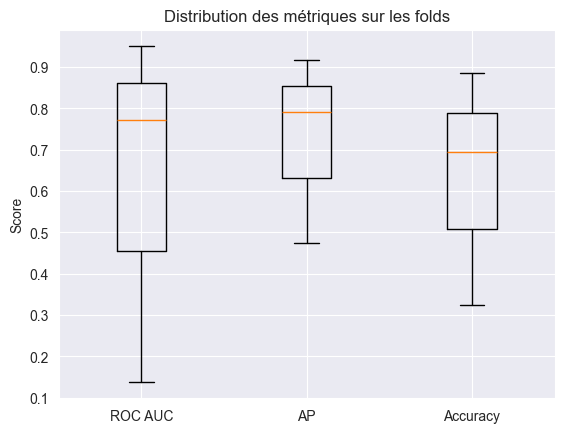

In [18]:
plt.figure()
plt.boxplot([df_metrics['roc_auc'], df_metrics['avg_precision'], df_metrics['accuracy']],
            tick_labels=['ROC AUC','AP','Accuracy'])
plt.title("Distribution des métriques sur les folds")
plt.ylabel("Score")
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_folds_metrics.png"), dpi=300)
plt.show()


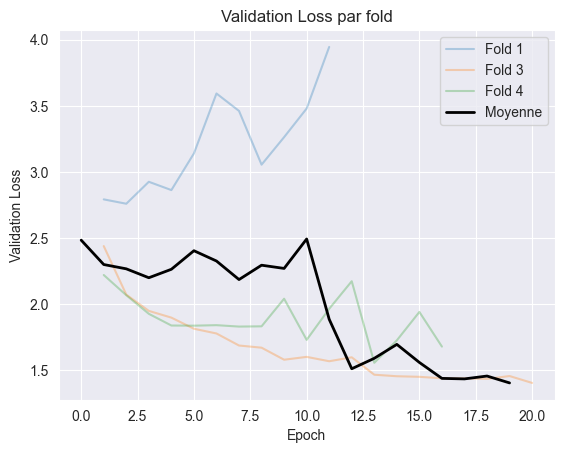

In [19]:
plt.figure()
for r in results:
    epochs = range(1, len(r['history']['val_loss'])+1)
    plt.plot(epochs, r['history']['val_loss'], alpha=0.3, label=f"Fold {r['fold']}")
# moyenne
mean_val = pd.DataFrame([r['history']['val_loss'] for r in results]).mean()
epochs = mean_val.index
plt.plot(epochs, mean_val, color='black', linewidth=2, label='Moyenne')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss par fold")
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_folds_loss.png"), dpi=300)
plt.show()


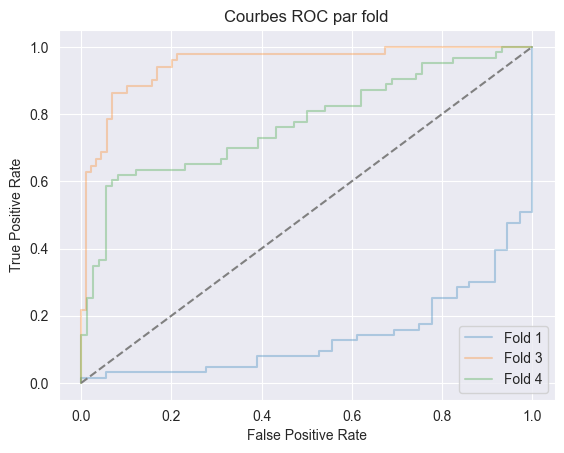

In [20]:
plt.figure()
for r in results:
    y_true = r['y_true']
    y_prob = r['y_prob']
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, alpha=0.3, label=f"Fold {r['fold']}")

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbes ROC par fold")
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_folds_roc.png"), dpi=300)
plt.show()


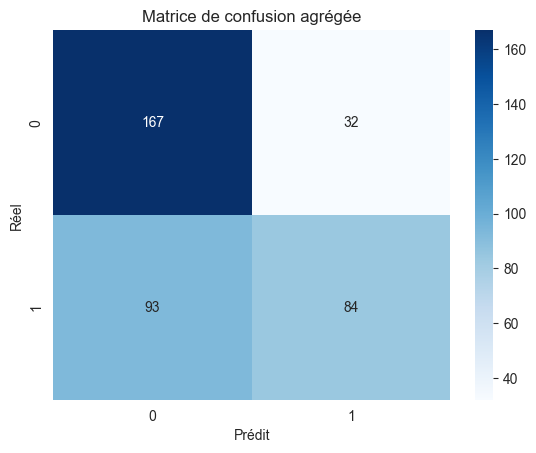

In [21]:
cm_sum = sum(r['confusion_matrix'] for r in results)
plt.figure()
sns.heatmap(cm_sum, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion agrégée")
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_aggregate_confusion_matrix.png"), dpi=300)
plt.show()


## 6. Save Model & Config

In [22]:
# Sauvegarde du modèle et de la config
os.makedirs('../outputs/checkpoints/Switzerland/finetune_resnet18', exist_ok=True)
torch.save(model.state_dict(),
           f'../outputs/checkpoints/Switzerland/finetune_resnet18/{run_id}_model.pth')

os.makedirs('../outputs/configs/Switzerland', exist_ok=True)
with open(f'../outputs/configs/Switzerland/{run_id}_config_finetune_resnet18.yaml', 'w') as f:
    yaml.dump(config, f)

print('Entraînement terminé. Modèle et config enregistrés.')


Entraînement terminé. Modèle et config enregistrés.


## 7. Test

In [23]:
class ToxicityDataset(Dataset):
    def __init__(self, root_dirs, transform=None):
        """
        root_dirs : list de chemins, par ex. ["../data/raw/NewZealand", "../data/raw/USA"]
        Chaque sous-dossier contient deux dossiers "toxic" et "non_toxic".
        """
        self.samples = []
        self.transform = transform
        for country_dir in root_dirs:
            for label_name, label_id in [("non_toxic", 0), ("toxic", 1)]:
                folder = os.path.join(country_dir, label_name)
                for fname in os.listdir(folder):
                    if fname.lower().endswith(('.png','.jpg','.jpeg','.tif')):
                        self.samples.append((os.path.join(folder, fname), label_id))
        # optionnel : shuffle pour mélanger
        # random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [27]:
# --- 1. Config et device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = "../models/cv_resnet18/fold1_model.pth"  # ajuster le chemin vers le .pth

# --- 3. Chargement du modèle
model = models.resnet18(weights=None)
in_feats = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=config["training"]["dropout_prob"]),
    torch.nn.Linear(in_feats, 2)
)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.to(device).eval()

# --- 4. Chargement des datasets hors-souche
country_dirs = ["../data/raw/NewZealand", "../data/raw/USA"]
dataset = ToxicityDataset(country_dirs, transform=val_transform)
loader  = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

# --- 5. Boucle d'inférence
all_probs = []
all_preds = []
all_labels = []

th = config['inference']['thresholds_per_fold']['fold_1']
T  = config['inference']['temperature']

print(th)
print(T)

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        logits = logits / T
        probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        preds = (probs >= th)
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# --- 6. Metrics
acc = accuracy_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)
class_names = ['non_toxic', 'toxic']
report = classification_report(all_labels, all_preds, target_names=class_names)
cm = confusion_matrix(all_labels, all_preds)

print(f"Hors‑souche (USA+NZ) — Accuracy: {acc:.3f}, AUC: {auc:.3f}")
print("Classification Report :\n", report)
print("Confusion Matrix :\n", cm)

0.4927164614200592
1.1955986022949219
Hors‑souche (USA+NZ) — Accuracy: 0.423, AUC: 0.327
Classification Report :
               precision    recall  f1-score   support

   non_toxic       0.27      0.06      0.10        99
       toxic       0.44      0.82      0.58        90

    accuracy                           0.42       189
   macro avg       0.36      0.44      0.34       189
weighted avg       0.35      0.42      0.33       189

Confusion Matrix :
 [[ 6 93]
 [16 74]]
